<a href="https://colab.research.google.com/github/ssyss-513/MyColab/blob/main/COMP5511/5511_a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 4.4 MB/s eta 0:00:00


In [2]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt

# DEAP imports
from deap import base, creator, tools, algorithms
import deap.creator as deap_creator  # to allow deletion of pre-created classes


In [3]:
# ---------------------------
# Helper: safely (re)create DEAP creator classes
# ---------------------------
def reset_deap_creator(fitness_name="FitnessMin", ind_name="Individual"):
    for name in (fitness_name, ind_name):
        if hasattr(deap_creator, name):
            try:
                delattr(deap_creator, name)
            except Exception:
                pass

reset_deap_creator()


In [11]:
# ---------------------------
# Load VRP.csv
# ---------------------------
csv_path = "VRP.csv"
df = pd.read_csv(csv_path, dtype=str)

# Normalize and decide columns
if "NO" in df.columns and any(c.upper().find("CUST") >= 0 for c in df.columns if isinstance(c, str)):
    # try to map standard column names
    cols = {c.upper(): c for c in df.columns}
    col_type = None
    for candidate in ["CUST OR DEPOT", "TYPE", "CUST_OR_DEPOT", "CUST/DEPOT"]:
        if candidate in cols:
            col_type = cols[candidate]
            break
    if col_type is None:
        col_type = df.columns[0]
    col_no = cols.get("NO", df.columns[1] if len(df.columns) > 1 else df.columns[0])
    candidate_coords = [c for c in df.columns if any(x in c.upper() for x in ["X", "LONG", "COORD", "LAT", "Y"])]
    col_x = candidate_coords[0] if len(candidate_coords) >= 1 else df.columns[2]
    col_y = candidate_coords[1] if len(candidate_coords) >= 2 else df.columns[3]
    col_demand = next((c for c in df.columns if "DEMAND" in c.upper()), df.columns[-1])
    df = df.rename(columns={col_type: "TYPE", col_no: "NO", col_x: "XCOORD", col_y: "YCOORD", col_demand: "DEMAND"})
else:
    # fallback: no header
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 5:
        raise ValueError("VRP.csv seems to have fewer than 5 columns.")
    df = df.rename(columns={0: "TYPE", 1: "NO", 2: "XCOORD", 3: "YCOORD", 4: "DEMAND"})

# Convert dtypes
df["TYPE"] = df["TYPE"].astype(str).str.strip()
df["NO"] = df["NO"].astype(int)
df["XCOORD"] = pd.to_numeric(df["XCOORD"])
df["YCOORD"] = pd.to_numeric(df["YCOORD"])
df["DEMAND"] = pd.to_numeric(df["DEMAND"])


In [5]:
df.head(10)

,TYPE,NO,XCOORD,YCOORD,DEMAND,EFFICIENCY
0,DEPOT,0,20.00,20.00,0,0.0
1,DEPOT,1,80.00,20.00,0,0.0
2,DEPOT,2,50.00,50.00,0,0.0
3,DEPOT,3,20.00,80.00,0,0.0
4,DEPOT,4,80.00,80.00,0,0.0
5,CUSTOMER,5,63.94,2.50,9,70.93
6,CUSTOMER,6,10.25,74.07,18,54.77
7,CUSTOMER,7,9.37,23.27,20,79.83
8,CUSTOMER,8,64.99,54.49,8,91.73
9,CUSTOMER,9,86.93,75.88,6,101.04


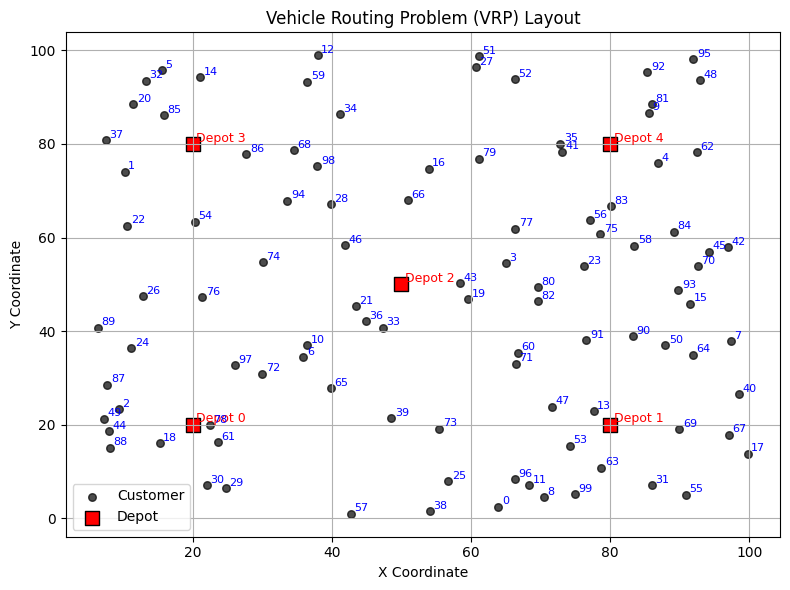

In [6]:
import matplotlib.pyplot as plt

# 分离仓库和客户
depots = df[df["TYPE"].str.upper().str.contains("DEPOT")]
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")]

plt.figure(figsize=(8, 6))

# 绘制客户点
plt.scatter(customers["XCOORD"], customers["YCOORD"],
            c='black', label='Customer', s=30, alpha=0.7)

# 绘制仓库点（红色方块）
plt.scatter(depots["XCOORD"], depots["YCOORD"],
            c='red', marker='s', label='Depot', s=100, edgecolors='black')

# 添加标注
for _, row in depots.iterrows():
    plt.text(row["XCOORD"]+0.5, row["YCOORD"]+0.5, f'Depot {int(row["NO"])}', color='red', fontsize=9)
for _, row in customers.iterrows():
    plt.text(row["XCOORD"]+0.5, row["YCOORD"]+0.5, str(int(row["NO"]-5)), color='blue', fontsize=8)

# 美化图形
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Vehicle Routing Problem (VRP) Layout")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        105 non-null    object 
 1   NO          105 non-null    int64  
 2   XCOORD      105 non-null    float64
 3   YCOORD      105 non-null    float64
 4   DEMAND      105 non-null    int64  
 5   EFFICIENCY  105 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 5.1+ KB


In [7]:
# Utility: Euclidean distance

def distance(a, b):
    return math.hypot(a[0] - b[0], a[1] - b[1])


In [12]:
# ==============================
# Q1: Classical VRP (Robust version)
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random





# -----------------------------
# 2. Split depot and customers
# -----------------------------
depot_row = df[df["TYPE"].str.upper().str.contains("DEPOT")].iloc[0]
depot_no = int(depot_row["NO"])
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy()

coords = {int(row["NO"]):(row["XCOORD"], row["YCOORD"]) for _,row in df.iterrows()}
demands = {int(row["NO"]):float(row["DEMAND"]) for _,row in df.iterrows()}
CAPACITY = 200

idx_to_cust = list(customers["NO"])

# -----------------------------
# 3. Distance matrix
# -----------------------------
def build_distance_matrix(coords):
    nodes = sorted(coords.keys())
    n = len(nodes)
    arr = np.array([coords[k] for k in nodes])
    diff = arr[:,None,:] - arr[None,:,:]
    dist = np.sqrt((diff**2).sum(axis=2))
    node_to_index = {node:i for i,node in enumerate(nodes)}
    return dist, node_to_index

dist_matrix, node_to_index = build_distance_matrix(coords)

# -----------------------------
# 4. Evaluation function
# -----------------------------
def eval_vrp_classical(individual):
    PENALTY = 1e7
    total_dist = 0.0
    load = 0.0
    cur = depot_no
    segments = []
    seg = [depot_no]

    for idx in individual:
        cust = idx_to_cust[idx]
        load += demands[cust]
        if load > CAPACITY:  # 超载回仓
            total_dist += dist_matrix[node_to_index[cur], node_to_index[depot_no]]
            segments.append(seg + [depot_no])
            seg = [depot_no]
            load = demands[cust]
            cur = depot_no
        total_dist += dist_matrix[node_to_index[cur], node_to_index[cust]]
        seg.append(cust)
        cur = cust

    total_dist += dist_matrix[node_to_index[cur], node_to_index[depot_no]]
    seg.append(depot_no)
    segments.append(seg)

    return (total_dist,), segments

# -----------------------------
# 5. GA setup
# -----------------------------
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(idx_to_cust)), len(idx_to_cust))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate_only(ind):
    val, _ = eval_vrp_classical(ind)
    return val

toolbox.register("evaluate", evaluate_only)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)



/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


⚠️ 未找到历史最优解文件，将随机初始化种群
gen	nevals	avg    	min    	max    
0  	100   	5630.71	5061.22	6046.45
1  	73    	5549.09	5046.28	6056.49
2  	79    	5444.61	5045.03	5987.28
3  	78    	5375.51	4868.91	5912.26
4  	86    	5333.78	4942.52	5896.37
5  	81    	5205.94	4874.32	5676.93
6  	76    	5155.71	4763.27	5724.51
7  	73    	5064.8 	4570.58	5565.9 
8  	75    	5017.92	4694.2 	5466.35
9  	76    	4981.69	4561.74	5555.29
10 	80    	4923.24	4366.87	5497.88
11 	81    	4851.02	4310.79	5491.59
12 	79    	4843.38	4310.79	5455.87
13 	80    	4786.57	4310.79	5308.15
14 	81    	4761.76	4351.05	5535.27
15 	73    	4702.37	4351.05	5198.4 
16 	76    	4694.86	4250.05	5204.74
17 	71    	4642.2 	4250.05	5345.43
18 	74    	4627.81	4040   	5177.42
19 	75    	4589.33	4196.4 	5156.57
20 	80    	4612.5 	4190.06	5182.92
21 	76    	4575.82	4101.74	5296.41
22 	74    	4546.67	4052.46	5424.94
23 	77    	4533.67	4052.46	5080.1 
24 	81    	4552.66	4048.65	5412.52
25 	80    	4508.98	4041.78	5201.13
26 	75    	4483.42	4052.46	5103.

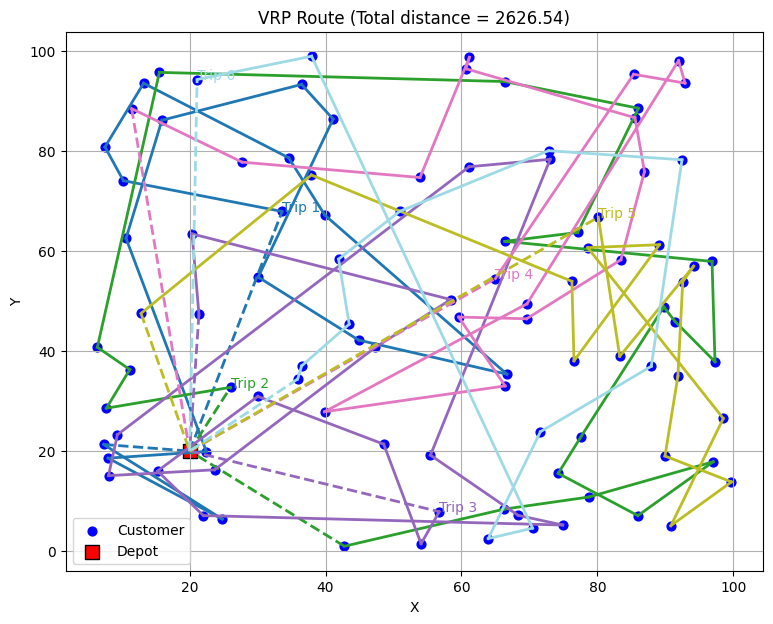

In [13]:

# -----------------------------
# 5. 读取历史最优解（如果存在）
# -----------------------------
try:
    with open("best_solutions.pkl", "rb") as f:
        saved_solutions = pickle.load(f)
    print(f"✅ 读取了 {len(saved_solutions)} 个历史最优解")
    # 用保存的个体初始化种群前 N 个
    initial_pop = [creator.Individual(sol["individual"]) for sol in saved_solutions]
except FileNotFoundError:
    print("⚠️ 未找到历史最优解文件，将随机初始化种群")
    initial_pop = []
# -----------------------------
# 6. Run GA
# -----------------------------
n_random = max(0, 100 - len(initial_pop))  # 剩余个体随机生成
pop = initial_pop + [toolbox.individual() for _ in range(n_random)]
hof = tools.HallOfFame(1)
hof_save = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.25, ngen=800,
                    stats=stats, halloffame=hof, verbose=True)

best = hof[0]
best_val, best_segments = eval_vrp_classical(best)
print(f"\n✅ Best distance: {best_val[0]:.2f}")

# -----------------------------
# 7. Visualization
# -----------------------------
plt.figure(figsize=(9,7))
plt.scatter(customers["XCOORD"], customers["YCOORD"], c='blue', s=40, label="Customer")
plt.scatter(depot_row["XCOORD"], depot_row["YCOORD"], c='red', marker='s', s=100,
            edgecolors='black', label="Depot")

colors = plt.cm.tab20(np.linspace(0,1,len(best_segments)))

for i, seg in enumerate(best_segments):
    for j in range(len(seg)-1):
        x1, y1 = coords[seg[j]]
        x2, y2 = coords[seg[j+1]]

        # 判断路线类型
        if seg[j] == depot_no or seg[j+1] == depot_no:
            # depot 到客户 或客户回 depot
            plt.plot([x1, x2], [y1, y2], color=colors[i], lw=2, linestyle='--')
        else:
            # 客户到客户
            plt.plot([x1, x2], [y1, y2], color=colors[i], lw=2, linestyle='-')

    # 标记每次行程
    plt.text(coords[seg[1]][0], coords[seg[1]][1], f"Trip {i+1}", color=colors[i])

# 添加图例，说明虚线和实线
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Customer → Customer'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Depot → Customer / Customer → Depot')
]
plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

plt.title(f"VRP Route (Total distance = {best_val[0]:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pickle

best_solutions = []
for i, ind in enumerate(hof_save):
    val, segments = eval_vrp_multi_depot(ind)
    best_solutions.append({"individual": ind, "fitness": val[0], "segments": segments})
    print(f"\nTop {i+1} distance: {val[0]:.2f}")
    for j, s in enumerate(segments):
        print(f"  Trip {j+1}: {' -> '.join(map(str,s))}")

with open("best_solutions.pkl", "wb") as f:
    pickle.dump(best_solutions, f)

print("\n✅ 前10个最优解已保存到 best_solutions.pkl")


✅ 前10个最优解已保存到 best_solutions.pkl


# 多仓库

0 [1, 2, 3, 4]
⚠️ 未找到历史最优解文件，将随机初始化种群
gen	nevals	avg    	min    	max    
0  	100   	5426.02	4655.75	6109.86
1  	82    	5289.48	4889.52	5944.79
2  	62    	5183.34	4679.12	5546.35
3  	86    	5141.64	4662.17	5789.96
4  	81    	5091.75	4707.88	5516.56
5  	81    	5027.65	4607.23	5528.25
6  	83    	5016.78	4607.23	5540.06
7  	80    	4958.98	4640.51	5373.75
8  	76    	4913.96	4576.06	5436.9 
9  	77    	4910.69	4531.45	5380.68
10 	79    	4890.35	4545.74	5414.03
11 	75    	4846.74	4485.19	5298.71
12 	90    	4847.27	4485.19	5520.76
13 	82    	4782.45	4356.08	5383.75
14 	81    	4722.09	4358.4 	5337.16
15 	80    	4682.88	4358.4 	5456.02
16 	67    	4607.27	4306.83	5071.69


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


17 	79    	4565.8 	4234.56	5049.43
18 	82    	4567.53	4219.63	5002.22
19 	70    	4528.13	4103.45	4952.57
20 	79    	4550.29	4108.61	5048.36
21 	79    	4523.46	4108.61	5094.12
22 	87    	4534.31	4108.61	5100.86
23 	83    	4505.53	4083.37	5147.5 
24 	75    	4471   	4083.37	5124.44
25 	79    	4459.8 	4052.05	5180.74
26 	87    	4481.52	4079.56	5064.17
27 	84    	4402.86	3729.98	5025.89
28 	70    	4347.94	3729.98	5133.77
29 	74    	4291.78	3729.98	4864.47
30 	75    	4229.69	3835.13	4802.91
31 	76    	4241.2 	3835.13	4809.87
32 	85    	4238.63	3816.67	5058.88
33 	81    	4216.47	3816.67	4776.21
34 	81    	4231.2 	3803.77	4695.21
35 	82    	4221.26	3717.43	4966.32
36 	78    	4232.48	3880.51	4802.11
37 	79    	4224.07	3750.13	4852.44
38 	91    	4220.93	3668.75	4885.29
39 	70    	4175.2 	3668.75	4870.49
40 	85    	4160.92	3740.58	4861.9 
41 	87    	4165.92	3595.24	4854.31
42 	81    	4146.11	3595.24	4875.3 
43 	73    	4119   	3728.23	4772.17
44 	84    	4089.69	3728.23	4684.35
45 	76    	4074.93	3

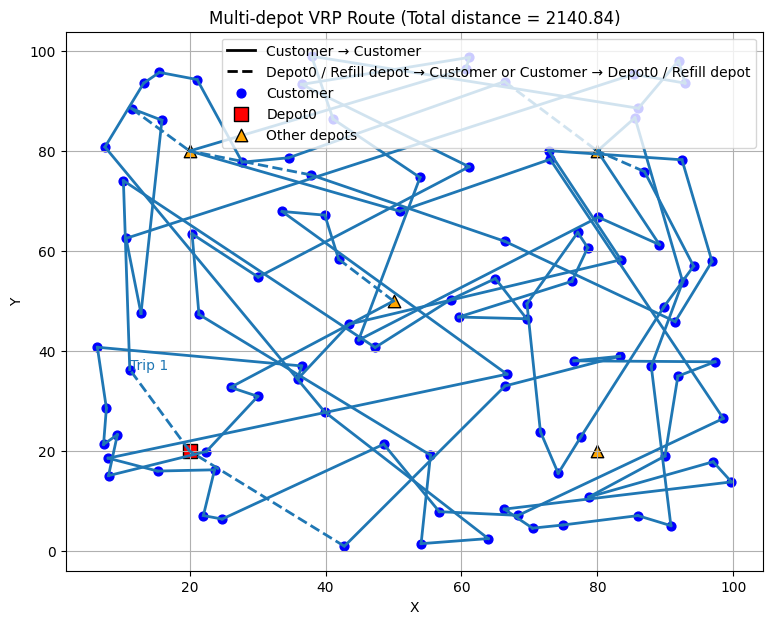

In [ ]:
# ==============================
# Q1: Multi-depot VRP (Depot0 start/end, others as refill)
# ==============================

# -----------------------------
# 2. Split depot0, other depots, customers
# -----------------------------
# 所有仓库
depots = df[df["TYPE"].str.upper().str.contains("DEPOT")]
# 自行选择主仓库，例如 NO 最小的
main_depot_row = depots.iloc[depots["NO"].idxmin()]
main_depot_no = int(main_depot_row["NO"])

# 其他补货仓库
other_depots = depots[depots["NO"] != main_depot_no]
other_depot_nos = list(other_depots["NO"])

# 客户
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy()
idx_to_cust = list(customers["NO"])
print(main_depot_no,other_depot_nos)

# Coordinates & demands
coords = {int(row["NO"]):(row["XCOORD"], row["YCOORD"]) for _,row in df.iterrows()}
demands = {int(row["NO"]):float(row["DEMAND"]) for _,row in df.iterrows()}
CAPACITY = 200

# -----------------------------
# 3. Distance matrix
# -----------------------------
def build_distance_matrix(coords):
    nodes = sorted(coords.keys())
    arr = np.array([coords[k] for k in nodes])
    diff = arr[:,None,:] - arr[None,:,:]
    dist = np.sqrt((diff**2).sum(axis=2))
    node_to_index = {node:i for i,node in enumerate(nodes)}
    return dist, node_to_index

dist_matrix, node_to_index = build_distance_matrix(coords)

# -----------------------------
# 4. Evaluation function with multi-depot refill
# -----------------------------
def eval_vrp_multi_depot(individual):
    total_dist = 0.0
    load = 0.0
    cur = main_depot_no
    segments = []
    seg = [main_depot_no]

    for idx in individual:
        cust = idx_to_cust[idx]
        load += demands[cust]

        # 如果超载，先去最近补货仓库
        while load > CAPACITY:
            if other_depot_nos:
                nearest_depot = min(other_depot_nos, key=lambda d: dist_matrix[node_to_index[cur], node_to_index[d]])
            else:
                nearest_depot = main_depot_no  # 没有其他仓库则回主仓库
            total_dist += dist_matrix[node_to_index[cur], node_to_index[nearest_depot]]
            seg.append(nearest_depot)
            cur = nearest_depot
            load = demands[cust]  # 补货后重新装载

        total_dist += dist_matrix[node_to_index[cur], node_to_index[cust]]
        seg.append(cust)
        cur = cust

    # 最后回主仓库
    total_dist += dist_matrix[node_to_index[cur], node_to_index[main_depot_no]]
    seg.append(main_depot_no)
    segments.append(seg)



    return (total_dist,), segments

# -----------------------------
# 5. GA setup (same as before)
# -----------------------------
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(idx_to_cust)), len(idx_to_cust))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", lambda ind: eval_vrp_multi_depot(ind)[0])
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# -----------------------------
# 5. 读取历史最优解（如果存在）
# -----------------------------
try:
    with open("best_solutions_multi.pkl", "rb") as f:
        saved_solutions = pickle.load(f)
    print(f"✅ 读取了 {len(saved_solutions)} 个历史最优解")
    # 用保存的个体初始化种群前 N 个
    initial_pop = [creator.Individual(sol["individual"]) for sol in saved_solutions]
except FileNotFoundError:
    print("⚠️ 未找到历史最优解文件，将随机初始化种群")
    initial_pop = []
# -----------------------------
# 6. Run GA
# -----------------------------

n_random = max(0, 100 - len(initial_pop))  # 剩余个体随机生成
pop = initial_pop + [toolbox.individual() for _ in range(n_random)]
hof = tools.HallOfFame(1)
hof_save = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=2000,
                    stats=stats, halloffame=hof, verbose=True)

best = hof[0]
best_val, best_segments = eval_vrp_multi_depot(best)
print(f"\n✅ Best distance: {best_val[0]:.2f}")

# 打印每次 trip 的路线
for i, s in enumerate(best_segments):
    print(f"Trip {i+1}: {' -> '.join(map(str,s))}")

# -----------------------------
# 7. Visualization
# -----------------------------
plt.figure(figsize=(9,7))
plt.scatter(customers["XCOORD"], customers["YCOORD"], c='blue', s=40, label="Customer")
plt.scatter(main_depot_row["XCOORD"], main_depot_row["YCOORD"], c='red', marker='s', s=100,
            edgecolors='black', label="Depot0")
plt.scatter(other_depots["XCOORD"], other_depots["YCOORD"], c='orange', marker='^', s=80,
            edgecolors='black', label="Other depots")

colors = plt.cm.tab20(np.linspace(0,1,len(best_segments)))

for i, seg in enumerate(best_segments):
    for j in range(len(seg)-1):
        x1, y1 = coords[seg[j]]
        x2, y2 = coords[seg[j+1]]
        # 虚线: depot0 或其他补货仓库
        if seg[j] == main_depot_no or seg[j+1] == main_depot_no or seg[j+1] in other_depot_nos:
            plt.plot([x1,x2],[y1,y2], color=colors[i], lw=2, linestyle='--')
        else:
            plt.plot([x1,x2],[y1,y2], color=colors[i], lw=2)

    plt.text(coords[seg[1]][0], coords[seg[1]][1], f"Trip {i+1}", color=colors[i])

# 图例
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0],[0], color='black', lw=2, linestyle='-', label='Customer → Customer'),
    Line2D([0],[0], color='black', lw=2, linestyle='--', label='Depot0 / Refill depot → Customer or Customer → Depot0 / Refill depot')
]
plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

plt.title(f"Multi-depot VRP Route (Total distance = {best_val[0]:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


In [ ]:
import pickle

best_solutions = []
for i, ind in enumerate(hof_save):
    val, segments = eval_vrp_multi_depot(ind)
    best_solutions.append({"individual": ind, "fitness": val[0], "segments": segments})
    print(f"\nTop {i+1} distance: {val[0]:.2f}")
    for j, s in enumerate(segments):
        print(f"  Trip {j+1}: {' -> '.join(map(str,s))}")

with open("best_solutions_multi.pkl", "wb") as f:
    pickle.dump(best_solutions, f)

print("\n✅ 前10个最优解已保存到 best_solutions_multi.pkl")


✅ 前10个最优解已保存到 best_solutions_multi.pkl


# Q2

gen	nevals	avg    	min    	max 
0  	100   	5456.26	5061.01	5856
1  	69    	5327.27	4817.84	5857.71
2  	79    	5243.72	4916.59	5687.16
3  	74    	5178.89	4801.8 	5560.37
4  	78    	5100.83	4687.33	5465.94
5  	88    	5067.09	4713.03	5413.09
6  	72    	5015.01	4689.19	5733.17
7  	85    	4944.42	4607.21	5363.8 
8  	85    	4896.35	4442.84	5361.71
9  	88    	4833.41	4437.42	5362.13
10 	70    	4781.01	4218.39	5275.72
11 	69    	4708.06	4218.39	5205.76
12 	68    	4680.71	4285.49	5255.91
13 	75    	4631.06	4285.49	5137.88
14 	64    	4561.94	4279.92	5186.28
15 	71    	4549.38	4242.33	5114.74
16 	80    	4491.55	4193.2 	5105.17
17 	76    	4455.07	4029.49	5061.03
18 	82    	4438.5 	4145.54	4897.87
19 	80    	4462.18	4145.54	5002.95
20 	72    	4442.45	4036.39	5021.92
21 	71    	4369.44	4036.39	4977.68
22 	75    	4389.35	4036.39	4811.9 
23 	77    	4334.96	4002.89	4921.32
24 	84    	4349.18	3956.54	4893.44
25 	68    	4277.49	4036.39	4959.62
26 	77    	4284.47	4036.09	4818.84
27 	78    	4284.23	4034.52

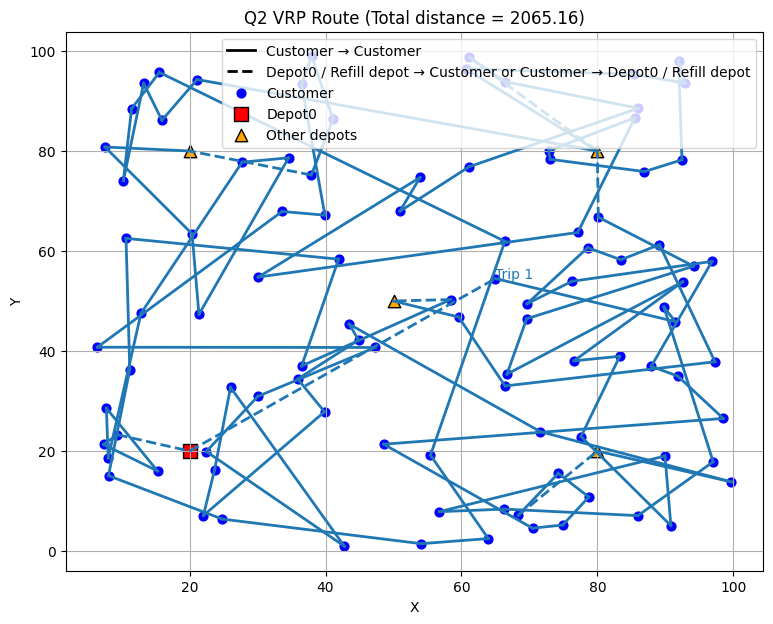

In [ ]:
# @title
# ===============================
# Q2 随机需求版修改（与你的变量命名保持一致）
# ===============================

import numpy as np
import pickle
from deap import algorithms, base, creator, tools

CAPACITY = 200
MC_SAMPLES = 50   # 每个个体 Monte Carlo 模拟次数，可根据性能调整
PENALTY = 1e6      # 不可行惩罚项，越大越重视可行性

# 所有仓库编号
depots = list(df[df["TYPE"].str.upper().str.contains("DEPOT")]["NO"])
depot_main = main_depot_no   # 主仓库编号
cust_nodes = list(customers["NO"])  # 客户编号
demands = dict(zip(df["NO"], df["DEMAND"]))  # 编号到需求的映射

# ---------- 生成截断正态需求 ----------
def sample_demands(mean_demands):
    """从 N(mean, 0.2*mean) 采样，负值重采样为正整数"""
    sampled = {}
    for k, mu in mean_demands.items():
        if mu <= 0:
            sampled[k] = 0
        else:
            sd = 0.2 * mu
            x = np.random.normal(mu, sd)
            while x <= 0:
                x = np.random.normal(mu, sd)
            sampled[k] = int(round(x))
    return sampled


# ---------- 计算一次样本下的路径距离 ----------
def compute_distance_with_sample(individual, sampled_demands):
    total_dist = 0
    load = 0
    cur = depot_main  # 从主仓出发
    feasible = True
    seg = [cur]
    segs = []

    for idx in individual:
        cust = cust_nodes[idx]
        demand = sampled_demands[cust]

        # 若单客户需求超过载重 -> 不可行
        if demand > CAPACITY:
            return float('inf'), [], False

        # 若当前载重不足，则去最近补货仓库补货
        if load + demand > CAPACITY:
            if len(depots) > 1:
                nearest = min([d for d in depots if d != depot_main],
                              key=lambda d: dist_matrix[cur, d])
            else:
                nearest = depot_main
            total_dist += dist_matrix[cur, nearest]
            seg.append(nearest)
            cur = nearest
            load = 0
        # 去客户
        total_dist += dist_matrix[cur, cust]
        cur = cust
        load += demand
        seg.append(cust)

    # 回主仓
    total_dist += dist_matrix[cur, depot_main]
    seg.append(depot_main)
    segs.append(seg)
    return total_dist, segs, feasible


# ---------- Monte Carlo 多次评估 ----------
def mc_evaluate(individual):
    total_dists = []
    feasible_count = 0

    for _ in range(MC_SAMPLES):
        sampled = sample_demands(demands)
        dist_val, _, feasible = compute_distance_with_sample(individual, sampled)
        if feasible and dist_val < 1e9:
            feasible_count += 1
        total_dists.append(dist_val)

    avg_dist = np.mean(total_dists)
    feas_rate = feasible_count / MC_SAMPLES
    score = avg_dist + PENALTY * (1 - feas_rate)
    return (score,)


# ---------- 替换 GA 评估函数 ----------
toolbox.register("evaluate", mc_evaluate)


# ---------- 运行 GA ----------
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop = toolbox.population(n=100)
pop, log = algorithms.eaSimple(
    pop, toolbox, cxpb=0.7, mutpb=0.2,
    ngen=400, stats=stats, halloffame=hof, verbose=True
)

best = hof[0]
best_val, best_segments = eval_vrp_multi_depot(best)
print(f"\n✅ Best distance: {best_val[0]:.2f}")

# -----------------------------
# 7. Visualization
# -----------------------------
plt.figure(figsize=(9,7))
plt.scatter(customers["XCOORD"], customers["YCOORD"], c='blue', s=40, label="Customer")
plt.scatter(main_depot_row["XCOORD"], main_depot_row["YCOORD"], c='red', marker='s', s=100,
            edgecolors='black', label="Depot0")
plt.scatter(other_depots["XCOORD"], other_depots["YCOORD"], c='orange', marker='^', s=80,
            edgecolors='black', label="Other depots")

colors = plt.cm.tab20(np.linspace(0,1,len(best_segments)))

for i, seg in enumerate(best_segments):
    for j in range(len(seg)-1):
        x1, y1 = coords[seg[j]]
        x2, y2 = coords[seg[j+1]]
        # 虚线: depot0 或其他补货仓库
        if seg[j] == main_depot_no or seg[j+1] == main_depot_no or seg[j+1] in other_depot_nos:
            plt.plot([x1,x2],[y1,y2], color=colors[i], lw=2, linestyle='--')
        else:
            plt.plot([x1,x2],[y1,y2], color=colors[i], lw=2)

    plt.text(coords[seg[1]][0], coords[seg[1]][1], f"Trip {i+1}", color=colors[i])

# 图例
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0],[0], color='black', lw=2, linestyle='-', label='Customer → Customer'),
    Line2D([0],[0], color='black', lw=2, linestyle='--', label='Depot0 / Refill depot → Customer or Customer → Depot0 / Refill depot')
]
plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

plt.title(f"Q2 VRP Route (Total distance = {best_val[0]:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

save result

In [ ]:
# @title
# ---------- 保存前10个最优解 ----------
best_solutions = []
for i, ind in enumerate(hof):
    avg_dist = mc_evaluate(ind)[0]
    sampled = sample_demands(demands)
    dist_val, segs, feasible = compute_distance_with_sample(ind, sampled)
    best_solutions.append({
        "rank": i + 1,
        "individual": list(ind),
        "avg_distance": avg_dist,
        "segments": segs,
        "feasible": feasible
    })
    print(f"Top {i+1}: avg_dist={avg_dist:.2f}")

with open("best_solutions.pkl", "wb") as f:
    pickle.dump(best_solutions, f)
print("✅ 已保存前10个最优解到 best_solutions.pkl")

In [ ]:
# @title
#Q2

import numpy as np

def sample_demand(original_mean):
    """
    Sample truncated normal demand:
      N(mean, 0.2*mean), truncated to positive integer (>=0)
    """
    mu = original_mean
    sigma = max(1e-9, 0.2 * original_mean)  # avoid zero
    # simple truncation at 0, sample until positive
    val = -1
    while val <= 0:
        val = np.random.normal(mu, sigma)
    return int(round(val))

def eval_vrp_stochastic_singleobj(individual, M=50, PENALTY=1e6):
    """
    Stochastic-demand single-objective fitness.
    - M: number of Monte Carlo demand realizations to average over
    - PENALTY: per-infeasible-run penalty added to distance
    Returns (score,) where smaller is better.
    """
    total_score = 0.0
    feasible_count = 0
    for _ in range(M):
        # sample demands for all customers (dict)
        sampled_demands = {cid: sample_demand(demands[cid]) for cid in demands if cid != depot_no}
        # run route
        total_dist = 0.0
        load = 0.0
        current = depot_no
        infeasible = False
        for idx in individual:
            cust = idx_to_cust[idx]
            total_dist += distance(coords[current], coords[cust])
            load += sampled_demands.get(cust, 0)
            if load > CAPACITY + 1e-9:
                infeasible = True
            current = cust
        total_dist += distance(coords[current], coords[depot_no])
        if infeasible:
            total_score += (total_dist + PENALTY)
        else:
            total_score += total_dist
            feasible_count += 1
    expected_score = total_score / M
    feasibility_rate = feasible_count / M

    return (expected_score,)

toolbox.register("evaluate", eval_vrp_stochastic_singleobj)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Q3 cluster


In [ ]:
# @title
# -----------------------------
# Q3: Large-scale VRP by duplicating customers and clustering
# 直接接在已有 Q1 代码后面（使用已有 df, customers, coords, demands, depot_no, idx_to_cust, dist_matrix 等）
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 1) 生成 100 个额外客户（通过将每个客户 Y 坐标 +150）
#    假设原来有 N customers；我们从 those customers 中选前100来平移（或复制所有并取前100）
orig_customers_df = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy()
N_orig = orig_customers_df.shape[0]

# 决定新 NO 的起始编号（以原数据最大 NO + 1）
max_no = int(df["NO"].max())
new_rows = []
for i in range(100):
    src = orig_customers_df.iloc[i % N_orig]  # 循环使用原客户以生成 100
    max_no += 1
    new_row = src.copy()
    new_row["NO"] = int(max_no)
    new_row["YCOORD"] = float(src["YCOORD"]) + 150.0
    # DEMAND 与原相同
    new_rows.append(new_row)

# 把新 customers 加入 df 与 customers DataFrame
new_customers_df = pd.DataFrame(new_rows)
# 更新 df、customers、coords、demands、idx_to_cust 等
df = pd.concat([df, new_customers_df], ignore_index=True)
# 重新构造 customers（排除 DEPOT）
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy().reset_index(drop=True)
# 重建 coords 与 demands
coords = {int(row["NO"]):(row["XCOORD"], row["YCOORD"]) for _,row in df.iterrows()}
demands = {int(row["NO"]):float(row["DEMAND"]) for _,row in df.iterrows()}
idx_to_cust = list(customers["NO"])
print(f"[Q3] 总客户数 = {len(idx_to_cust)} (应该为 200)。主仓库 NO = {depot_no}")

In [ ]:
# @title


# 2) 构建距离矩阵（覆盖所有节点）
def build_distance_matrix_from_coords(coords):
    nodes = sorted(coords.keys())
    arr = np.array([coords[k] for k in nodes])
    diff = arr[:,None,:] - arr[None,:,:]
    dist = np.sqrt((diff**2).sum(axis=2))
    node_to_index = {node:i for i,node in enumerate(nodes)}
    # print(node_to_index)
    print(f"Building distance matrix for {len(coords)} nodes.")

    return dist, node_to_index, nodes

dist_matrix, node_to_index, all_nodes_sorted = build_distance_matrix_from_coords(coords)
# 为兼容后续使用，创建快速访问函数 dist[a,b]
dist = {}
for a in all_nodes_sorted:
    for b in all_nodes_sorted:
        dist[(a,b)] = float(dist_matrix[node_to_index[a], node_to_index[b]])

# 3) 聚类（优先尝试 sklearn.KMeans；若不可用则使用简易实现）
K_CLUSTERS = max(5, int(np.sqrt(len(idx_to_cust))))  # 聚类个数的启发式选择，可调整
customer_coords = np.array([coords[n] for n in idx_to_cust])

try:
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=2).fit(customer_coords)
    labels = kmeans.labels_
    print(f"[Q3] 使用 sklearn KMeans，K = {K_CLUSTERS}")
except Exception as e:
    # 简易KMeans实现（Lloyd）
    print("[Q3] sklearn 未安装或不可用，使用简易 KMeans 回退实现。")
    def simple_kmeans(X, k, iters=50):
        n = X.shape[0]
        idx = np.random.choice(n, k, replace=False)
        centers = X[idx].copy()
        labels = np.zeros(n, dtype=int)
        for _ in range(iters):
            dists = np.linalg.norm(X[:,None,:] - centers[None,:,:], axis=2)
            new_labels = np.argmin(dists, axis=1)
            if np.all(new_labels == labels):
                break
            labels = new_labels
            for j in range(k):
                pts = X[labels==j]
                if len(pts)>0:
                    centers[j] = pts.mean(axis=0)
        return labels, centers
    labels, centers = simple_kmeans(customer_coords, K_CLUSTERS)
    labels = np.array(labels)

# map customer NO -> cluster label
cust_to_cluster = {cust: int(labels[i]) for i, cust in enumerate(idx_to_cust)}
cluster_to_customers = defaultdict(list)
for cust in idx_to_cust:
    cluster_to_customers[cust_to_cluster[cust]].append(cust)

num_clusters = len(cluster_to_customers)
print(f"[Q3] 得到 {num_clusters} 个簇。每簇大小示例（前5簇）：", {c: len(cluster_to_customers[c]) for c in list(cluster_to_customers)[:5]})


Building distance matrix for 205 nodes.
[Q3] 使用 sklearn KMeans，K = 14
[Q3] 得到 14 个簇。每簇大小示例（前5簇）： {4: 20, 10: 16, 8: 15, 11: 22, 3: 14}


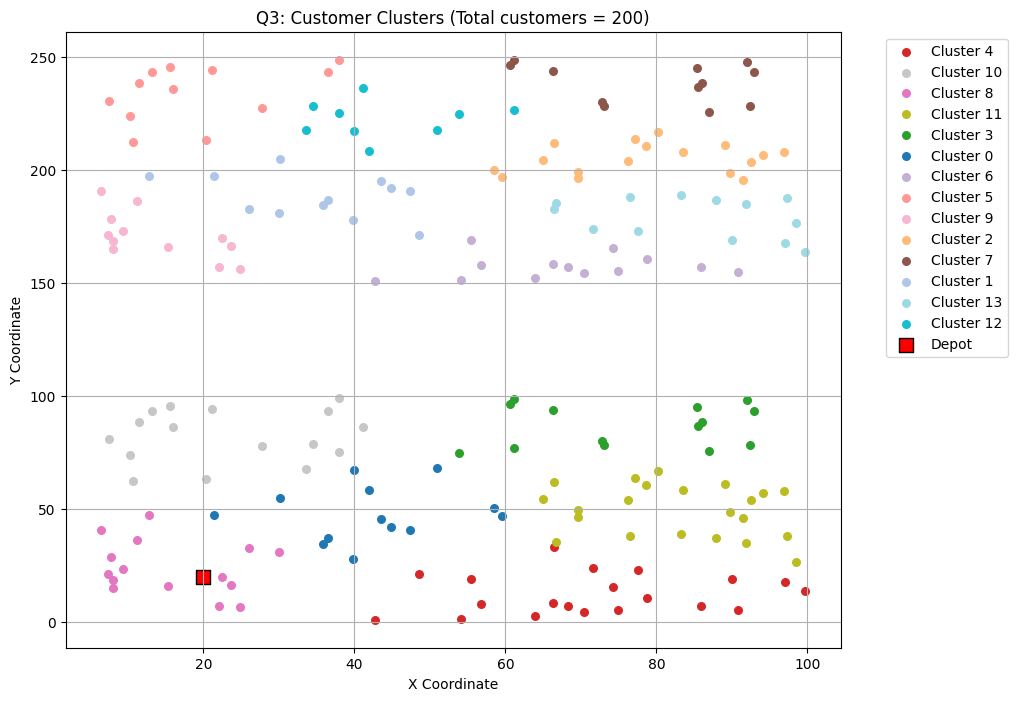

In [ ]:
# @title
# 设置颜色，每个簇一种颜色
colors = plt.cm.tab20(np.linspace(0,1,num_clusters))

plt.figure(figsize=(10,8))

# 绘制每个簇的客户
for cluster_id, cust_list in cluster_to_customers.items():
    x = [coords[c][0] for c in cust_list]
    y = [coords[c][1] for c in cust_list]
    plt.scatter(x, y, color=colors[cluster_id], label=f'Cluster {cluster_id}', s=30)

# 绘制主仓库
plt.scatter(coords[depot_no][0], coords[depot_no][1], c='red', marker='s', s=100, edgecolors='black', label='Depot')

plt.title(f"Q3: Customer Clusters (Total customers = {len(idx_to_cust)})")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 图例在右侧
plt.show()

In [ ]:
print(dist_matrix)
df.head(3)

[[  0.          60.          42.42640687 ... 162.85130641 205.98011579
  145.93064825]
 [ 60.           0.          42.42640687 ... 171.45888137 209.47221319
  135.30614953]
 [ 42.42640687  42.42640687   0.         ... 134.88865038 175.61665098
  108.11639145]
 ...
 [162.85130641 171.45888137 134.88865038 ...   0.          44.09335211
   56.09951248]
 [205.98011579 209.47221319 175.61665098 ...  44.09335211   0.
   79.16350295]
 [145.93064825 135.30614953 108.11639145 ...  56.09951248  79.16350295
    0.        ]]


,TYPE,NO,XCOORD,YCOORD,DEMAND,EFFICIENCY
0,DEPOT,0,20.0,20.0,0,0.0
1,DEPOT,1,80.0,20.0,0,0.0
2,DEPOT,2,50.0,50.0,0,0.0


[Q3] Gen 1: min=7058.74, avg=7527.57
[Q3] Gen 10: min=6690.98, avg=7249.24
[Q3] Gen 20: min=6592.15, avg=7022.56
[Q3] Gen 30: min=6547.46, avg=6738.53
[Q3] Gen 40: min=6377.23, avg=6690.90
[Q3] Gen 50: min=6271.48, avg=6459.47
[Q3] Gen 60: min=6225.19, avg=6328.07
[Q3] Gen 70: min=6225.19, avg=6311.44
[Q3] Gen 80: min=6198.20, avg=6301.55
[Q3] Gen 90: min=6136.24, avg=6344.23
[Q3] Gen 100: min=6136.24, avg=6212.99
[Q3] Gen 110: min=6136.24, avg=6264.95
[Q3] Gen 120: min=6136.24, avg=6244.52
[Q3] Gen 130: min=6112.02, avg=6212.18
[Q3] Gen 140: min=6097.47, avg=6247.81
[Q3] Gen 150: min=6068.44, avg=6177.58
[Q3] Gen 160: min=6044.55, avg=6196.99
[Q3] Gen 170: min=6044.55, avg=6142.75
[Q3] Gen 180: min=6013.61, avg=6194.16
[Q3] Gen 190: min=5975.67, avg=6184.10
[Q3] Gen 200: min=5939.09, avg=6043.36
[Q3] Gen 210: min=5939.09, avg=6067.78
[Q3] Gen 220: min=5939.09, avg=6078.04
[Q3] Gen 230: min=5939.09, avg=6074.18
[Q3] Gen 240: min=5939.09, avg=6058.84
[Q3] Gen 250: min=5939.09, avg=6063.

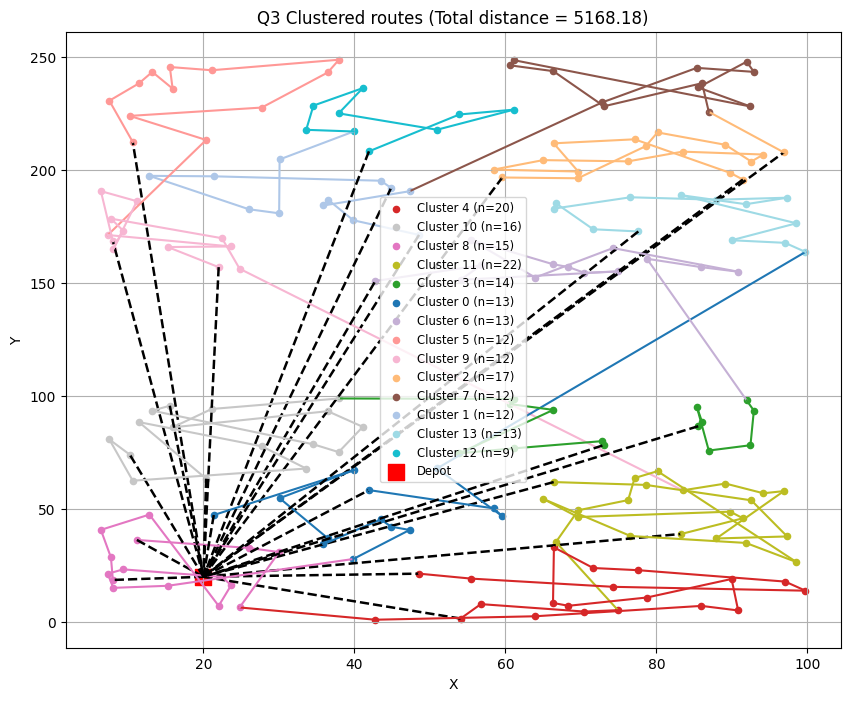

[Q3] Saved q3_best_solution.pkl


In [ ]:
# @title

# 4) 构造 GA 个体：我们用「客户索引的全序列」表示个体，但保证在评估前用 repair() 将其调整为“簇块连续”
#    初始个体生成函数会随机生成簇顺序 + 每簇内部随机排列并串联
from deap import base, creator, tools, algorithms
creator.create("FitnessMin_Q3", base.Fitness, weights=(-1.0,))
creator.create("Individual_Q3", list, fitness=creator.FitnessMin_Q3)
toolbox_q3 = base.Toolbox()

cluster_ids = sorted(cluster_to_customers.keys())

def gen_grouped_individual():
    # 随机簇顺序
    region_order = cluster_ids.copy()
    random.shuffle(region_order)
    seq = []
    for cid in region_order:
        custs = cluster_to_customers[cid].copy()
        random.shuffle(custs)
        seq.extend(custs)
    # seq 是客户 NO 的序列，需要转换为 idx (0..n-1) 表示 customers 中的位置，便于与现有 eval 接口兼容
    # 构造 cust -> index_in_idx_to_cust 映射
    idx_map = {cust:i for i,cust in enumerate(idx_to_cust)}
    seq_idx = [idx_map[c] for c in seq]
    return creator.Individual_Q3(seq_idx)

toolbox_q3.register("individual", gen_grouped_individual)
toolbox_q3.register("population", tools.initRepeat, list, toolbox_q3.individual)

# repair：把任意序列调整为“簇块连续”——簇顺序按照首次出现顺序决定，簇内保持原相对顺序
def repair_region_blocks(individual):
    # individual: list of idx into idx_to_cust
    # produce customer NO sequence
    seq_nos = [idx_to_cust[i] for i in individual]
    seen = set()
    new_seq = []
    for node in seq_nos:
        c = cust_to_cluster[node]
        if c not in seen:
            seen.add(c)
            # append all nodes of this cluster in the order they appear in seq_nos
            cluster_nodes_in_order = [n for n in seq_nos if cust_to_cluster[n]==c]
            new_seq.extend(cluster_nodes_in_order)
    # now convert back to indices
    idx_map = {cust:i for i,cust in enumerate(idx_to_cust)}
    repaired = [idx_map[n] for n in new_seq]
    # replace content
    individual[:] = repaired
    return individual

# 定义评估函数，基于已有 eval_vrp_classical（它接收 individual as indices into idx_to_cust）
def evaluate_q3(individual):
    # repair first
    repair_region_blocks(individual)
    cost, segments = eval_vrp_classical(individual)
    return cost

# 注册遗传算子（使用 cxOrdered & mutShuffleIndexes，但在后处理对 offspring 进行 repair）
toolbox_q3.register("mate", tools.cxOrdered)
toolbox_q3.register("mutate", tools.mutShuffleIndexes, indpb=0.02)
toolbox_q3.register("select", tools.selTournament, tournsize=3)
toolbox_q3.register("evaluate", evaluate_q3)

# wrap crossover/mutation to apply repair on offspring
def cx_repair(a, b):
    tools.cxOrdered(a, b)
    repair_region_blocks(a)
    repair_region_blocks(b)
    return a, b

def mut_repair(ind):
    tools.mutShuffleIndexes(ind, indpb=0.02)
    repair_region_blocks(ind)
    return (ind,)

toolbox_q3.register("mate_repair", cx_repair)
toolbox_q3.register("mutate_repair", mut_repair)

# 5) 运行 GA（参数可调整）
POP_SIZE = 80
NGEN = 6000
CXPB = 0.7
MUTPB = 0.2

pop = toolbox_q3.population(n=POP_SIZE)
hof_q3 = tools.HallOfFame(3)  # 保存若干最优解
stats_q3 = tools.Statistics(lambda ind: ind.fitness.values)
stats_q3.register("avg", np.mean)
stats_q3.register("min", np.min)
stats_q3.register("max", np.max)

# custom evolve loop to apply repaired operators
for ind in pop:
    # ensure initial population obeys block structure
    repair_region_blocks(ind)
    ind.fitness.values = toolbox_q3.evaluate(ind)

for gen in range(1, NGEN+1):
    offspring = toolbox_q3.select(pop, len(pop))
    offspring = list(map(toolbox_q3.clone, offspring))
    # apply crossover on pairs
    for i in range(1, len(offspring), 2):
        if random.random() < CXPB:
            a, b = offspring[i-1], offspring[i]
            cx_repair(a, b)
            # invalidate fitness
            a.fitness.values = (float('inf'),)
            b.fitness.values = (float('inf'),)
    # mutation
    for i in range(len(offspring)):
        if random.random() < MUTPB:
            mut_repair(offspring[i])
            offspring[i].fitness.values = (float('inf'),)

    # evaluate invalid fitness
    invalid = [ind for ind in offspring if not hasattr(ind, "fitness") or ind.fitness.values[0] == float('inf')]
    for ind in invalid:
        ind.fitness.values = toolbox_q3.evaluate(ind)

    # replace population
    pop[:] = offspring
    # update hof and stats
    hof_q3.update(pop)
    record = stats_q3.compile(pop)
    if gen % 10 == 0 or gen==1 or gen==NGEN:
        print(f"[Q3] Gen {gen}: min={record['min']:.2f}, avg={record['avg']:.2f}")

print("[Q3] GA finished. Best objective (distance):", hof_q3[0].fitness.values[0])

# 6) 可视化：绘制聚类结果与最优路径（选择 hof_q3[0]）
best_ind = hof_q3[0]
repair_region_blocks(best_ind)
best_cost, best_segments = eval_vrp_classical(best_ind)
print(f"[Q3] Best total distance (classical eval): {best_cost[0]:.2f}")

# Prepare colors for clusters
colors = plt.cm.tab20(np.linspace(0,1,num_clusters))

plt.figure(figsize=(10,8))
# plot customers by cluster
for cid, custs in cluster_to_customers.items():
    xs = [coords[c][0] for c in custs]
    ys = [coords[c][1] for c in custs]
    plt.scatter(xs, ys, s=20, label=f"Cluster {cid} (n={len(custs)})", color=colors[cid % len(colors)])

# plot depot
depot_coord = coords[depot_no]
plt.scatter([depot_coord[0]], [depot_coord[1]], c='red', s=120, marker='s', label='Depot')

# plot route segments with cluster color, virtual line for depot->cluster boundary transitions
for i, seg in enumerate(best_segments):
    for j in range(len(seg)-1):
        a, b = seg[j], seg[j+1]
        x1, y1 = coords[a]
        x2, y2 = coords[b]
        # if either a or b is depot, draw as dashed
        if a == depot_no or b == depot_no:
            plt.plot([x1,x2],[y1,y2], linestyle='--', linewidth=1.8, color='k')
        else:
            cidx = cust_to_cluster[a]
            plt.plot([x1,x2],[y1,y2], linestyle='-', linewidth=1.5, color=colors[cidx % len(colors)])

plt.title(f"Q3 Clustered routes (Total distance = {best_cost[0]:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(scatterpoints=1, fontsize='small', loc='best')
plt.grid(True)
plt.show()

# 7) 保存最佳解（和聚类信息）
import pickle
out = {
    "best_individual_idx_seq": list(best_ind),
    "best_segments": best_segments,
    "best_distance": best_cost[0],
    "cust_to_cluster": dict(cust_to_cluster),
    "cluster_to_customers": dict(cluster_to_customers)
}
with open("q3_best_solution.pkl", "wb") as f:
    pickle.dump(out, f)
print("[Q3] Saved q3_best_solution.pkl")


# ------------------------------------------------------------------------**

# Q4 MULTI-OBJECTIVE OPTIMIZATION PROBLEM


=== Running NSGA-II ===
Gen 1: Pareto front size = 2 | sample objs: [(0.85, 0.46), (0.84, 0.24)]
Gen 50: Pareto front size = 9 | sample objs: [(0.57, 2.37), (0.57, 2.37), (0.57, 2.37), (0.57, 2.37), (0.57, 2.37)]
Gen 100: Pareto front size = 2 | sample objs: [(0.51, 3.07), (0.51, 3.07)]
Gen 150: Pareto front size = 183 | sample objs: [(0.49, 3.14), (0.49, 3.14), (0.49, 3.14), (0.49, 3.14), (0.49, 3.14)]
Gen 200: Pareto front size = 1 | sample objs: [(0.46, 3.31)]
Gen 250: Pareto front size = 200 | sample objs: [(0.46, 3.33), (0.46, 3.33), (0.46, 3.33), (0.46, 3.33), (0.46, 3.33)]
Gen 300: Pareto front size = 200 | sample objs: [(0.46, 3.34), (0.46, 3.34), (0.46, 3.34), (0.46, 3.34), (0.46, 3.34)]
Gen 350: Pareto front size = 56 | sample objs: [(0.46, 3.36), (0.46, 3.36), (0.46, 3.36), (0.46, 3.36), (0.46, 3.36)]
Gen 400: Pareto front size = 66 | sample objs: [(0.45, 3.45), (0.45, 3.45), (0.45, 3.45), (0.45, 3.45), (0.45, 3.45)]
Gen 450: Pareto front size = 200 | sample objs: [(0.44, 3

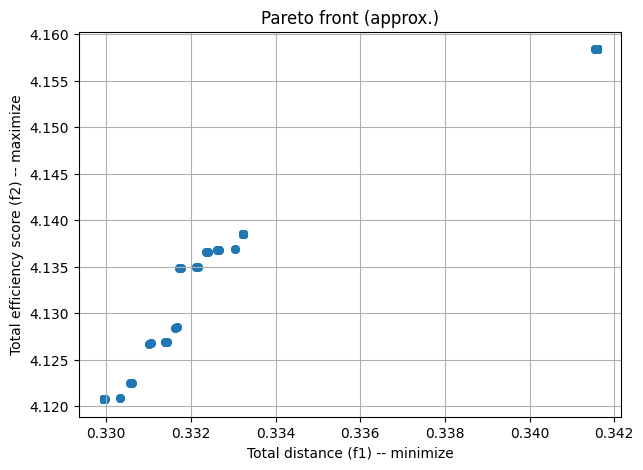

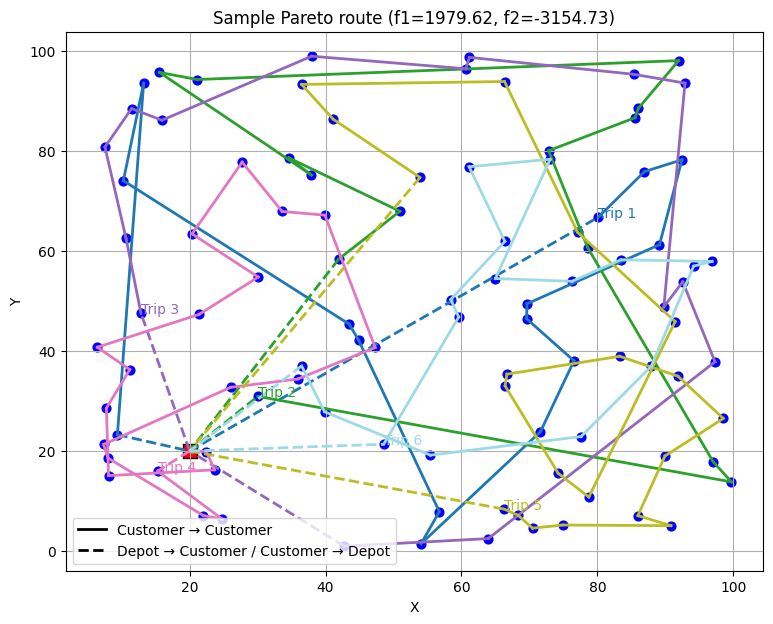

In [30]:
# -*- coding: utf-8 -*-
"""
Bi-objective VRP:
 - f1: total travel distance (minimize)
 - f2: sum_i (EFFICIENCY_i - d_i) (maximize), d_i = cumulative distance from depot to customer i along its trip
 Two solvers:
  - weighted-sum GA: f = w*f1 - (1-w)*f2  (minimize)
  - NSGA-II (Pareto) with objectives (f1, f2)
Requires: numpy, pandas, matplotlib, deap
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
import pickle
import os

# -----------------------------
# 0. Load VRP.csv (assume df already loaded in original code)
# If you already have df in env, skip this reading and comment out below.
# df = pd.read_csv("VRP.csv")
# -----------------------------

# ------------ (Keep your original df) -------------
# Assume df exists; if not, uncomment above line to read CSV
# ---------------------------------------------------

# -----------------------------
# 1. Parse depot / customers / data structures
# -----------------------------
# find depot row (same as your code)
depot_row = df[df["TYPE"].str.upper().str.contains("DEPOT")].iloc[0]
depot_no = int(depot_row["NO"])
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy()

coords = {int(row["NO"]):(float(row["XCOORD"]), float(row["YCOORD"])) for _,row in df.iterrows()}
demands = {int(row["NO"]):float(row["DEMAND"]) for _,row in df.iterrows()}
EFFICIENCY = {int(row["NO"]): float(row["EFFICIENCY"]) if "EFFICIENCY" in df.columns else 0.0 for _,row in df.iterrows()}
CAPACITY = 200

idx_to_cust = list(customers["NO"])  # map indices (0..n-1) to actual customer NO

# -----------------------------
# 2. Distance matrix (reuse)
# -----------------------------
def build_distance_matrix(coords):
    nodes = sorted(coords.keys())
    n = len(nodes)
    arr = np.array([coords[k] for k in nodes], dtype=float)
    diff = arr[:,None,:] - arr[None,:,:]
    dist = np.sqrt((diff**2).sum(axis=2))
    node_to_index = {node:i for i,node in enumerate(nodes)}
    return dist, node_to_index

dist_matrix, node_to_index = build_distance_matrix(coords)

# -----------------------------
# 3. General evaluator: returns f1 (total dist), f2 (sum efficiency - d_i), segments
# -----------------------------
def eval_vrp_bi(individual):
    """
    Traverse permutation 'individual' (list of indices into idx_to_cust).
    Build segments (trips) split when capacity would be exceeded (start new trip from depot).
    Compute:
      f1 = total distance (including depot returns)
      f2 = sum_i (EFFICIENCY_i - d_i), where d_i is cumulative distance from depot along its trip
    Returns (f1, f2, segments)
    """
    total_dist = 0.0
    total_eff_pen = 0.0  # f2: sum(EFFICIENCY_i - d_i)
    load = 0.0
    cur = depot_no
    segments = []
    seg = [depot_no]
    # For tracking cumulative distance inside current segment
    cum_dist = 0.0

    for idx in individual:
        cust = idx_to_cust[idx]
        cust = int(cust)
        demand = demands.get(cust, 0.0)
        # if adding this customer exceeds capacity -> return to depot and start new trip
        if load + demand > CAPACITY:
            # return to depot
            total_dist += dist_matrix[node_to_index[cur], node_to_index[depot_no]]
            # close segment
            seg.append(depot_no)
            segments.append(seg)
            # reset for next trip
            seg = [depot_no]
            cur = depot_no
            load = 0.0
            cum_dist = 0.0

        # travel from cur to cust
        dist = dist_matrix[node_to_index[cur], node_to_index[cust]]
        total_dist += dist
        cum_dist += dist  # cumulative distance from depot along this segment/trip to reach this customer
        # efficiency contribution: EFFICIENCY_i - d_i
        effi = EFFICIENCY.get(cust, 0.0)
        total_eff_pen += (effi - cum_dist)

        # append
        seg.append(cust)
        cur = cust
        load += demand

    # finish last segment: return to depot
    total_dist += dist_matrix[node_to_index[cur], node_to_index[depot_no]]
    seg.append(depot_no)
    segments.append(seg)

    f1 = total_dist
    f2 = total_eff_pen
    return f1, f2, segments

# -----------------------------
# 4. Weighted single-objective GA
# -----------------------------
def run_weighted_ga(w=0.5, pop_size=100, ngen=400, cxpb=0.7, mutpb=0.25, save_best=True):
    """
    w in [0,1]. Objective f = w*f1 - (1-w)*f2  (minimize)
    Returns best individual, its f1,f2,segments
    """
    # create single-objective fitness class (unique name to avoid deap creator collision)
    try:
        creator.create("FitnessWeighted", base.Fitness, weights=(-1.0,))
    except Exception:
        # maybe already created
        pass
    try:
        creator.create("IndividualW", list, fitness=creator.FitnessWeighted)
    except Exception:
        pass

    toolbox_w = base.Toolbox()
    toolbox_w.register("indices", random.sample, range(len(idx_to_cust)), len(idx_to_cust))
    toolbox_w.register("individual", tools.initIterate, creator.IndividualW, toolbox_w.indices)
    toolbox_w.register("population", tools.initRepeat, list, toolbox_w.individual)

    def eval_weighted(ind):
        f1, f2, _ = eval_vrp_bi(ind)
        val = w * f1 - (1.0 - w) * f2
        return (val,)

    toolbox_w.register("evaluate", eval_weighted)
    toolbox_w.register("mate", tools.cxOrdered)
    toolbox_w.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox_w.register("select", tools.selTournament, tournsize=3)

    # initialize population (optionally from saved best_solutions.pkl)
    initial_pop = []
    if os.path.exists("best_solutions.pkl"):
        try:
            with open("best_solutions.pkl", "rb") as f:
                saved_solutions = pickle.load(f)
            for sol in saved_solutions:
                if "individual" in sol:
                    initial_pop.append(creator.IndividualW(sol["individual"]))
            print(f"Loaded {len(initial_pop)} saved individuals")
        except Exception:
            initial_pop = []

    n_random = max(0, pop_size - len(initial_pop))
    pop = initial_pop + [toolbox_w.individual() for _ in range(n_random)]

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox_w, cxpb=cxpb, mutpb=mutpb, ngen=ngen,
                        stats=stats, halloffame=hof, verbose=True)

    best = hof[0]
    f1, f2, segments = eval_vrp_bi(best)
    if save_best:
        # store best individual for later use
        saved = {"individual": list(best), "f1": float(f1), "f2": float(f2), "w": float(w)}
        try:
            prev = []
            if os.path.exists("best_solutions.pkl"):
                with open("best_solutions.pkl", "rb") as f:
                    prev = pickle.load(f)
            prev.insert(0, saved)
            # keep top 100
            prev = prev[:100]
            with open("best_solutions.pkl", "wb") as f:
                pickle.dump(prev, f)
        except Exception as e:
            print("Warning: could not save best_solutions:", e)

    return best, f1, f2, segments

def run_nsga2(pop_size=200, ngen=800, cxpb=0.7, mutpb=0.25, mu=None, lam=None):
    """
    Correct NSGA-II implementation using DEAP.
    Key points:
      - Create multi-objective Fitness with weights (-1.0, 1.0).
      - After initial evaluation call tools.selNSGA2(pop, len(pop)) to compute crowding_dist.
      - In each generation: select parents via selTournamentDCD (requires crowding_dist),
        variation, evaluate offspring, then select next gen via selNSGA2(pop+offspring, pop_size).
    Returns final population and Pareto front (first front).
    """
    # (Re)create classes robustly: delete if exist to ensure weights are correct
    try:
        if "FitnessMulti" in creator.__dict__:
            del creator.FitnessMulti
        if "IndividualM" in creator.__dict__:
            del creator.IndividualM
    except Exception:
        pass

    creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0))
    creator.create("IndividualM", list, fitness=creator.FitnessMulti)

    toolbox_m = base.Toolbox()
    toolbox_m.register("indices", random.sample, range(len(idx_to_cust)), len(idx_to_cust))
    toolbox_m.register("individual", tools.initIterate, creator.IndividualM, toolbox_m.indices)
    toolbox_m.register("population", tools.initRepeat, list, toolbox_m.individual)

        # ----------------- 归一化评估函数 -----------------
    f1_max = 6000.0   # 假设总距离最大值
    f2_min = -32000.0 # 假设 f2 最小值
    f2_max = -25000.0 # 假设 f2 最大值
    def eval_multi(ind):
        f1, f2, _ = eval_vrp_bi(ind)
        # 归一化
        f1_scaled = f1 / f1_max
        f2_scaled = (f2 - f2_min) / (f2_max - f2_min)
        return (f1_scaled, f2_scaled)

    toolbox_m.register("evaluate", eval_multi)
    toolbox_m.register("mate", tools.cxOrdered)
    toolbox_m.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    # keep selNSGA2 available via toolbox if desired, but we will call tools.selNSGA2 directly
    toolbox_m.register("select", tools.selNSGA2)

    # INIT population
    pop = toolbox_m.population(n=pop_size)

    # Evaluate initial population
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    for ind in invalid_ind:
        ind.fitness.values = toolbox_m.evaluate(ind)

    # CRITICAL: initialize crowding distances and dominance ranks for the population
    # This ensures .fitness.crowding_dist exists before calling selTournamentDCD
    pop = tools.selNSGA2(pop, len(pop))

    # Defaults
    if mu is None:
        mu = pop_size
    if lam is None:
        lam = pop_size

    # Evolutionary loop
    for gen in range(1, ngen + 1):
        # Parent selection for mating: selTournamentDCD requires crowding_dist to be set
        mating_pool = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox_m.clone(ind) for ind in mating_pool]

        # Variation (crossover + mutation)
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= cxpb:
                toolbox_m.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values
        for mutant in offspring:
            if random.random() <= mutpb:
                toolbox_m.mutate(mutant)
                del mutant.fitness.values

        # Evaluate invalid offspring
        invalid_off = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid_off:
            ind.fitness.values = toolbox_m.evaluate(ind)

        # Combine parent and offspring and select next generation via NSGA-II selection
        pop = tools.selNSGA2(pop + offspring, pop_size)

        if gen % 50 == 0 or gen == 1 or gen == ngen:
            pareto = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
            pareto_sample = [(round(float(ind.fitness.values[0]),2), round(float(ind.fitness.values[1]),2)) for ind in pareto[:5]]
            print(f"Gen {gen}: Pareto front size = {len(pareto)} | sample objs: {pareto_sample}")

    pareto = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    return pop, pareto


# -----------------------------
# 6. Plot helpers
# -----------------------------
def plot_route(segments, title=None):
    plt.figure(figsize=(9,7))
    plt.scatter(customers["XCOORD"], customers["YCOORD"], c='blue', s=40, label="Customer")
    plt.scatter(depot_row["XCOORD"], depot_row["YCOORD"], c='red', marker='s', s=100,
                edgecolors='black', label="Depot")

    colors = plt.cm.tab20(np.linspace(0,1,len(segments)))
    for i, seg in enumerate(segments):
        for j in range(len(seg)-1):
            x1, y1 = coords[seg[j]]
            x2, y2 = coords[seg[j+1]]
            if seg[j] == depot_no or seg[j+1] == depot_no:
                plt.plot([x1, x2], [y1, y2], color=colors[i], lw=2, linestyle='--')
            else:
                plt.plot([x1, x2], [y1, y2], color=colors[i], lw=2, linestyle='-')
        # mark first customer of trip
        if len(seg) > 2:
            plt.text(coords[seg[1]][0], coords[seg[1]][1], f"Trip {i+1}", color=colors[i])
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label='Customer → Customer'),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label='Depot → Customer / Customer → Depot')
    ]
    plt.legend(handles=legend_elements)
    if title:
        plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

def plot_pareto(pareto):
    # pareto: list of individuals (fitness values are tuples (f1,f2))
    f1s = [ind.fitness.values[0] for ind in pareto]
    f2s = [ind.fitness.values[1] for ind in pareto]
    plt.figure(figsize=(7,5))
    plt.scatter(f1s, f2s, s=30)
    plt.xlabel("Total distance (f1) -- minimize")
    plt.ylabel("Total efficiency score (f2) -- maximize")
    plt.title("Pareto front (approx.)")
    plt.grid(True)
    plt.show()

# -----------------------------
# 7. Example runs
# -----------------------------
if __name__ == "__main__":
    random.seed(42)
    # 1) Weighted GA: try a few w values
    for w in [0.0, 0.25, 0.5, 0.75, 1.0]:
        print(f"\n=== Running weighted GA with w={w} ===")
        best, f1, f2, segments = run_weighted_ga(w=w, pop_size=120, ngen=30, cxpb=0.7, mutpb=0.2, save_best=False)
        print(f"w={w} -> f1={f1:.2f}, f2={f2:.2f}")
        plot_route(segments, title=f"Weighted GA (w={w}) f1={f1:.2f}, f2={f2:.2f}")

    # 2) NSGA-II
    # print("\n=== Running NSGA-II ===")
    # pop, pareto = run_nsga2(pop_size=200, ngen=4000, cxpb=0.7, mutpb=0.25)
    # print(f"Final Pareto size: {len(pareto)}")
    # show a few pareto solutions
    # for i, ind in enumerate(pareto[:8]):
        # f1, f2 = ind.fitness.values
        # print(f"Pareto {i+1}: f1={f1:.2f}, f2={f2:.2f}")
    # plot_pareto(pareto)
    # plot one representative route from pareto (e.g., smallest f1)
    # pareto_sorted_by_f1 = sorted(pareto, key=lambda ind: ind.fitness.values[0])
    # sample = pareto_sorted_by_f1[0]
    # f1samp, f2samp, segsamp = eval_vrp_bi(sample)
    # plot_route(segsamp, title=f"Sample Pareto route (f1={f1samp:.2f}, f2={f2samp:.2f})")
